# 15.1c: Initialization Robustness Test

**Test reproducibility of lattice coincidence patterns across multiple runs**

## Hypothesis

If f32→bf16 conversion consistently creates persistent discrete structure:
- **bf16 init:** Should collapse to 0-1 lattice coincidences within 1000 steps (all dead tokens on same grid point)
- **f32 init:** Should maintain multiple lattice coincidences (tokens spread across grid)

**Lattice coincidence** = multiple tokens at same bfloat16 grid point (population ≥ 2)

## Experimental Design

- **10 runs** with bf16 initialization, 1000 steps each
- **10 runs** with f32→bf16 initialization, 1000 steps each
- **Different random seeds** for each run (42-51)
- Record only: step number + count of lattice coincidences
- Lightweight output (~KB, not GB)

## Success Criteria

- bf16 runs: ≥8/10 collapse to ≤1 coincidence by t=1000
- f32 runs: ≥8/10 maintain ≥5 coincidences by t=1000
- Clear separation between the two distributions

## Parameters

In [15]:
# Model architecture
VOCAB_SIZE = 128
HIDDEN_DIM = 64
N_LAYER = 2
N_HEAD = 2
MAX_SEQ_LEN = 128

# Training
BATCH_SIZE = 64
GRADIENT_ACCUMULATION = 1
NUM_TRAIN_STEPS = 2000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.01

# Adam parameters
ADAM_BETA1 = 0.9
ADAM_BETA2 = 0.999
ADAM_EPSILON = 1e-8

# Initialization
INIT_SIGMA = 1e-5

# Experiment
N_RUNS = 10
BASE_SEED = 42
RECORD_EVERY_N_STEPS = 1

# Data
CORPUS_PATH = "../data/training_corpus.txt"
OUTPUT_DIR = "../data/robustness_test"

# Plot settings
DPI = 100

## Imports

In [16]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import save_file
from tqdm import tqdm
import time

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Load Corpus (Once)

In [17]:
print(f"Loading corpus: {CORPUS_PATH}")

with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = [b for b in corpus_text.encode('ascii') if b < VOCAB_SIZE]
unique_bytes = set(corpus_bytes)
dead_token_ids = sorted(set(range(VOCAB_SIZE)) - unique_bytes)
live_token_ids = sorted(unique_bytes)

print(f"  Total bytes: {len(corpus_bytes):,}")
print(f"  Live tokens: {len(live_token_ids)} / {VOCAB_SIZE}")
print(f"  Dead tokens: {len(dead_token_ids)} / {VOCAB_SIZE}")

corpus_tensor = torch.tensor(corpus_bytes, dtype=torch.long, device=device)
print(f"\n✓ Corpus loaded")

Loading corpus: ../data/training_corpus.txt
  Total bytes: 265,905
  Live tokens: 77 / 128
  Dead tokens: 51 / 128

✓ Corpus loaded


## Dataset Class

In [18]:
class ByteDataset(Dataset):
    def __init__(self, corpus_tensor, max_seq_len):
        self.corpus = corpus_tensor
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return max(0, len(self.corpus) - self.max_seq_len)
    
    def __getitem__(self, idx):
        chunk = self.corpus[idx : idx + self.max_seq_len + 1]
        return {
            'input_ids': chunk[:-1],
            'labels': chunk[1:]
        }

dataset = ByteDataset(corpus_tensor, MAX_SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} examples")

✓ Dataset: 265,777 examples


## Lightweight Tracker

Only records lattice coincidence count, not full embeddings

In [19]:
class CoincidenceTracker:
    """Lightweight tracker: only counts lattice coincidences at each step."""
    
    def __init__(self, dead_token_ids, record_every_n):
        self.dead_token_ids = dead_token_ids
        self.record_every_n = record_every_n
        
        self.recorded_steps = []
        self.coincidence_counts = []  # Number of lattice coincidences (pop >= 2)
        
        self.current_step = 0
        self.recorded_initial = False
    
    def record_initial_state(self, model):
        """Record t=0."""
        if not self.recorded_initial:
            count = self._count_coincidences(model)
            self.recorded_steps.append(0)
            self.coincidence_counts.append(count)
            self.recorded_initial = True
            self.current_step = 1
    
    def record_step(self, model):
        """Record current step."""
        if self.current_step % self.record_every_n == 0:
            count = self._count_coincidences(model)
            self.recorded_steps.append(self.current_step)
            self.coincidence_counts.append(count)
        self.current_step += 1
    
    def _count_coincidences(self, model):
        """Count lattice coincidences among dead tokens."""
        with torch.no_grad():
            embeddings = model.transformer.wte.weight[self.dead_token_ids].cpu()
            unique_vecs, inverse_indices = torch.unique(embeddings, dim=0, return_inverse=True)
            populations = torch.bincount(inverse_indices)
            num_coincidences = (populations >= 2).sum().item()
            return num_coincidences
    
    def get_data(self):
        return {
            'steps': torch.tensor(self.recorded_steps, dtype=torch.long),
            'coincidence_counts': torch.tensor(self.coincidence_counts, dtype=torch.long)
        }

print("✓ CoincidenceTracker defined")

✓ CoincidenceTracker defined


## Training Function

In [20]:
def train_single_run(init_method, seed, run_idx, n_runs):
    """
    Train one model and return lattice coincidence trajectory.
    
    Args:
        init_method: 'f32_to_bf16' or 'pure_bf16'
        seed: Random seed
        run_idx: Current run number (for display)
        n_runs: Total number of runs (for display)
    
    Returns:
        dict with 'steps' and 'coincidence_counts'
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Create model
    config = GPT2Config(
        vocab_size=VOCAB_SIZE,
        n_positions=MAX_SEQ_LEN,
        n_embd=HIDDEN_DIM,
        n_layer=N_LAYER,
        n_head=N_HEAD,
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        tie_word_embeddings=True,
    )
    model = GPT2LMHeadModel(config).to(torch.bfloat16).to(device)
    
    # Initialize embeddings
    with torch.no_grad():
        if init_method == 'f32_to_bf16':
            # f32 → bf16
            random_vector = torch.randn(HIDDEN_DIM, dtype=torch.float32, device=device)
            random_vector = random_vector / random_vector.norm()
            noise = torch.randn(VOCAB_SIZE, HIDDEN_DIM, dtype=torch.float32, device=device) * INIT_SIGMA
            init_f32 = random_vector + noise
            init_bf16 = init_f32.to(torch.bfloat16)
        else:
            # pure bf16
            random_vector = torch.randn(HIDDEN_DIM, dtype=torch.bfloat16, device=device)
            random_vector = random_vector / random_vector.norm()
            noise = torch.randn(VOCAB_SIZE, HIDDEN_DIM, dtype=torch.bfloat16, device=device) * INIT_SIGMA
            init_bf16 = random_vector + noise
        
        model.transformer.wte.weight[:] = init_bf16
    
    # Create tracker
    tracker = CoincidenceTracker(dead_token_ids, RECORD_EVERY_N_STEPS)
    
    # Training args
    output_dir = Path(OUTPUT_DIR) / f"{init_method}_run_{run_idx}"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    training_args = TrainingArguments(
        output_dir=str(output_dir),
        max_steps=NUM_TRAIN_STEPS,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        adam_beta1=ADAM_BETA1,
        adam_beta2=ADAM_BETA2,
        adam_epsilon=ADAM_EPSILON,
        logging_steps=NUM_TRAIN_STEPS + 1,  # Suppress logging
        save_steps=NUM_TRAIN_STEPS + 1,  # Don't save checkpoints
        save_total_limit=0,
        dataloader_num_workers=0,
        dataloader_pin_memory=False,
        bf16=True,
        seed=seed,
        report_to="none",
        disable_tqdm=True,  # Suppress per-batch progress
    )
    
    # Custom trainer that records after each optimizer step
    class TrackedTrainer(Trainer):
        def __init__(self, tracker, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.tracker = tracker
        
        def _maybe_log_save_evaluate(self, tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval, start_time=None, **kwargs):
            self.tracker.record_step(model)
            super()._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval, start_time, **kwargs)
    
    trainer = TrackedTrainer(
        tracker=tracker,
        model=model,
        args=training_args,
        train_dataset=dataset,
    )
    
    # Record initial state
    tracker.record_initial_state(model)
    
    # Train
    print(f"  [{run_idx+1}/{n_runs}] {init_method} (seed={seed})...", end=" ", flush=True)
    start = time.time()
    trainer.train()
    elapsed = time.time() - start
    print(f"{elapsed:.1f}s")
    
    return tracker.get_data()

print("✓ Training function defined")

✓ Training function defined


## Run All Experiments

In [21]:
print(f"\n{'='*80}")
print(f"RUNNING {N_RUNS} × 2 = {N_RUNS*2} TRAINING RUNS")
print(f"  {NUM_TRAIN_STEPS} steps per run, record every {RECORD_EVERY_N_STEPS} steps")
print(f"{'='*80}\n")

results_f32 = []
results_bf16 = []

# f32→bf16 runs
print("f32→bf16 initialization:")
for i in range(N_RUNS):
    seed = BASE_SEED + i
    data = train_single_run('f32_to_bf16', seed, i, N_RUNS)
    results_f32.append(data)

print("\npure bf16 initialization:")
for i in range(N_RUNS):
    seed = BASE_SEED + i
    data = train_single_run('pure_bf16', seed, i, N_RUNS)
    results_bf16.append(data)

print(f"\n{'='*80}")
print("✓ All runs complete")
print(f"{'='*80}")


RUNNING 10 × 2 = 20 TRAINING RUNS
  2000 steps per run, record every 1 steps

f32→bf16 initialization:
  [1/10] f32_to_bf16 (seed=42)... {'train_runtime': 28.0679, 'train_samples_per_second': 4560.371, 'train_steps_per_second': 71.256, 'train_loss': 2.733032958984375, 'epoch': 0.4815795810257645}
28.2s
  [2/10] f32_to_bf16 (seed=43)... {'train_runtime': 27.5469, 'train_samples_per_second': 4646.613, 'train_steps_per_second': 72.603, 'train_loss': 2.794724365234375, 'epoch': 0.4815795810257645}
27.6s
  [3/10] f32_to_bf16 (seed=44)... {'train_runtime': 26.8139, 'train_samples_per_second': 4773.64, 'train_steps_per_second': 74.588, 'train_loss': 2.767017578125, 'epoch': 0.4815795810257645}
26.9s
  [4/10] f32_to_bf16 (seed=45)... {'train_runtime': 25.7036, 'train_samples_per_second': 4979.844, 'train_steps_per_second': 77.81, 'train_loss': 2.73437060546875, 'epoch': 0.4815795810257645}
25.8s
  [5/10] f32_to_bf16 (seed=46)... {'train_runtime': 25.6106, 'train_samples_per_second': 4997.927,

## Aggregate Results

In [22]:
# Stack into tensors [n_runs, n_recorded_steps]
steps = results_f32[0]['steps'].numpy()  # Same for all runs

counts_f32 = torch.stack([r['coincidence_counts'] for r in results_f32]).numpy()
counts_bf16 = torch.stack([r['coincidence_counts'] for r in results_bf16]).numpy()

print(f"Steps recorded: {len(steps)}")
print(f"f32→bf16 shape: {counts_f32.shape}")
print(f"pure bf16 shape: {counts_bf16.shape}")

Steps recorded: 2002
f32→bf16 shape: (10, 2002)
pure bf16 shape: (10, 2002)


## Save Results

In [23]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

save_dict = {
    'steps': torch.tensor(steps, dtype=torch.long),
    'counts_f32_to_bf16': torch.tensor(counts_f32, dtype=torch.long),
    'counts_pure_bf16': torch.tensor(counts_bf16, dtype=torch.long),
    'dead_token_ids': torch.tensor(dead_token_ids, dtype=torch.long),
    'n_runs': torch.tensor(N_RUNS, dtype=torch.long),
    'n_steps': torch.tensor(NUM_TRAIN_STEPS, dtype=torch.long),
    'record_every_n': torch.tensor(RECORD_EVERY_N_STEPS, dtype=torch.long),
    'base_seed': torch.tensor(BASE_SEED, dtype=torch.long),
}

output_path = Path(OUTPUT_DIR) / "robustness_test_results.safetensors"
save_file(save_dict, output_path)

file_size_kb = output_path.stat().st_size / 1e3
print(f"✓ Saved to: {output_path}")
print(f"  File size: {file_size_kb:.1f} KB (compare to ~660 MB for full instrumentation!)")

✓ Saved to: ../data/robustness_test/robustness_test_results.safetensors
  File size: 337.4 KB (compare to ~660 MB for full instrumentation!)


## Summary Statistics

In [24]:
print(f"\n{'='*80}")
print(f"SUMMARY STATISTICS")
print(f"{'='*80}\n")

# Initial state (t=0)
f32_t0 = counts_f32[:, 0]
bf16_t0 = counts_bf16[:, 0]

# Final state (t=1000)
f32_final = counts_f32[:, -1]
bf16_final = counts_bf16[:, -1]

print("f32→bf16 initialization:")
print(f"  t=0:    {f32_t0.mean():.1f} ± {f32_t0.std():.1f} coincidences (range: {f32_t0.min()}-{f32_t0.max()})")
print(f"  t=1000: {f32_final.mean():.1f} ± {f32_final.std():.1f} coincidences (range: {f32_final.min()}-{f32_final.max()})")

print(f"\npure bf16 initialization:")
print(f"  t=0:    {bf16_t0.mean():.1f} ± {bf16_t0.std():.1f} coincidences (range: {bf16_t0.min()}-{bf16_t0.max()})")
print(f"  t=1000: {bf16_final.mean():.1f} ± {bf16_final.std():.1f} coincidences (range: {bf16_final.min()}-{bf16_final.max()})")

# Success criteria
bf16_collapsed = (bf16_final <= 1).sum()
f32_maintained = (f32_final >= 5).sum()

print(f"\nSuccess criteria:")
print(f"  bf16 collapsed to ≤1: {bf16_collapsed}/{N_RUNS} runs ({'✓' if bf16_collapsed >= 8 else '✗'})")
print(f"  f32 maintained ≥5:   {f32_maintained}/{N_RUNS} runs ({'✓' if f32_maintained >= 8 else '✗'})")

print(f"\n{'='*80}")


SUMMARY STATISTICS

f32→bf16 initialization:
  t=0:    3.5 ± 3.4 coincidences (range: 0-10)
  t=1000: 6.6 ± 2.1 coincidences (range: 2-10)

pure bf16 initialization:
  t=0:    7.5 ± 3.4 coincidences (range: 0-12)
  t=1000: 1.6 ± 0.5 coincidences (range: 1-2)

Success criteria:
  bf16 collapsed to ≤1: 4/10 runs (✗)
  f32 maintained ≥5:   9/10 runs (✓)



## Plot All Trajectories

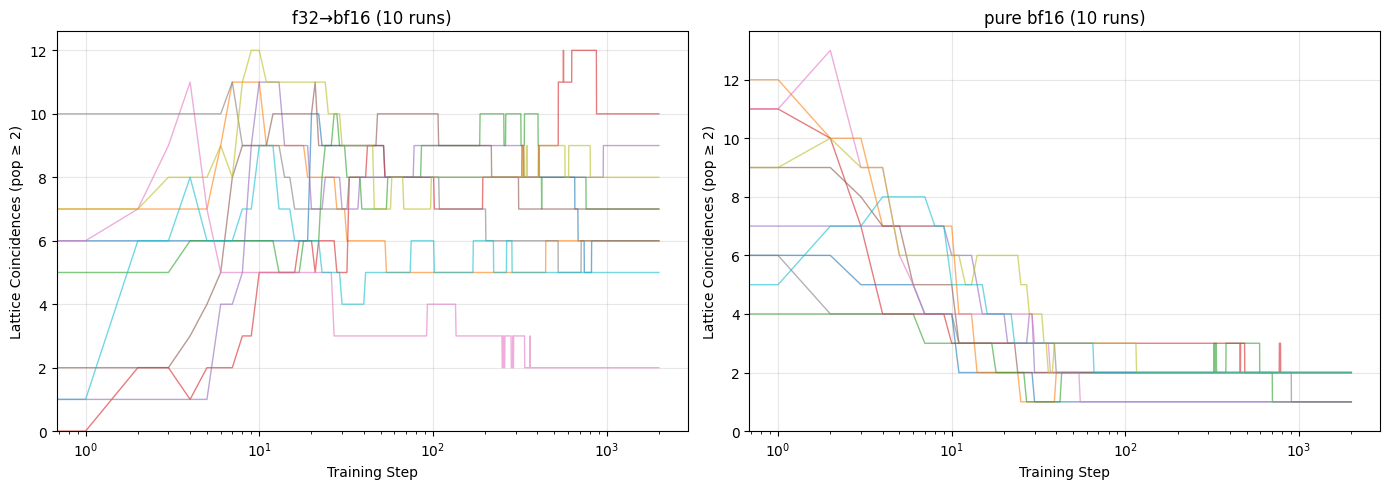


✓ Plot complete


In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# f32→bf16 trajectories
for i in range(N_RUNS):
    ax1.plot(steps, counts_f32[i], alpha=0.6, linewidth=1)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Lattice Coincidences (pop ≥ 2)')
ax1.set_title(f'f32→bf16 ({N_RUNS} runs)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)
ax1.set_xscale('log')

# pure bf16 trajectories
for i in range(N_RUNS):
    ax2.plot(steps, counts_bf16[i], alpha=0.6, linewidth=1)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Lattice Coincidences (pop ≥ 2)')
ax2.set_title(f'pure bf16 ({N_RUNS} runs)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n✓ Plot complete")

## Verdict

In [30]:
print(f"\n{'='*80}")
print(f"VERDICT")
print(f"{'='*80}\n")

if bf16_collapsed >= 8 and f32_maintained >= 8:
    verdict = "HYPOTHESIS CONFIRMED ✓"
    explanation = (
        f"Across {N_RUNS} independent runs:\n"
        f"  - pure bf16 consistently collapses to singularity\n"
        f"  - f32→bf16 consistently maintains multiple lattice coincidences\n"
        f"Pattern is REPRODUCIBLE and ROBUST."
    )
elif bf16_collapsed >= 5 or f32_maintained >= 5:
    verdict = "HYPOTHESIS PARTIALLY SUPPORTED ~"
    explanation = (
        f"Pattern exists but with high variance:\n"
        f"  - bf16 collapsed: {bf16_collapsed}/{N_RUNS}\n"
        f"  - f32 maintained: {f32_maintained}/{N_RUNS}\n"
        f"May need more runs or investigation of outliers."
    )
else:
    verdict = "HYPOTHESIS NOT SUPPORTED ✗"
    explanation = (
        f"No consistent pattern observed:\n"
        f"  - bf16 collapsed: {bf16_collapsed}/{N_RUNS}\n"
        f"  - f32 maintained: {f32_maintained}/{N_RUNS}\n"
        f"Initialization method may not be the primary factor."
    )

print(verdict)
print()
print(explanation)
print(f"\n{'='*80}")


VERDICT

HYPOTHESIS PARTIALLY SUPPORTED ~

Pattern exists but with high variance:
  - bf16 collapsed: 4/10
  - f32 maintained: 9/10
May need more runs or investigation of outliers.



## Summary

This notebook tests whether the f32→bf16 initialization effect is reproducible across multiple independent runs.

**Design:**
- 10 runs each of f32→bf16 and pure bf16 initialization
- 1000 training steps per run
- Different random seeds (42-51)
- Lightweight tracking (only lattice coincidence count)

**Expected outcome if hypothesis is robust:**
- ≥8/10 bf16 runs collapse to ≤1 coincidence
- ≥8/10 f32 runs maintain ≥5 coincidences
- Clear visual separation in trajectory plots

**Key advantage:** Small output file (~KB) allows quick iteration without storage concerns